# 07. Model Classification: Selection - PySpark

## 07.1. Importação das bibliotecas

### 07.1.1. Importando as bibliotecas nativas do Python

In [1]:
import sys
from typing import Any

### 07.1.2. Importando as bibliotecas de terceiros

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from pyspark.sql import SparkSession, types as T
from pyspark.sql.functions import *
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### 07.1.3. Importando os módulos locais do projeto

In [3]:
sys.path.append('..')
import functions.fn_charts_pandas as fn_charts_pandas
import functions.fn_stats_pyspark as fn_stats_pyspark
import params.consts as consts

## 07.2. Visão geral dos dados

### 07.2.0. Iniciando a sessão Spark

In [4]:
spark = SparkSession.builder.appName('spark').getOrCreate()

### 07.2.1. Habilitando a exibição de todas as colunas

In [5]:
pd.set_option('display.max_columns', None)

### 07.2.2. Armazenando o dataset em uma variável

In [6]:
df = spark.read \
    .format('parquet') \
    .load(consts.DATASET_CLUSTERED_PYSPARK)

### 07.2.3. Visualizando a quantidade de linhas e colunas do dataset

In [7]:
(df.count(), len(df.columns))

(2205, 23)

### 07.2.4. Exibindo o dataset

In [8]:
df.show(5)

+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
| Education|Marital_Status|Children|HasChildren|Age|AgeGroup| Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|Cluster|
+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|       PhD|        Single|       0|          0| 40|   31-45|63159.0|     74|  

### 07.2.5. Visualizando os detalhes do dataset

In [9]:
df.printSchema()

root
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Children: integer (nullable = true)
 |-- HasChildren: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Income: double (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Complain: integer (nullable = true)
 |-- Dt_Customer_Month: integer (nullable = true)
 |-- Dt_Customer_Quarter: integer (nullable = true)
 |-- Days_Since_Enrolled: integer (nullable = true)
 |-- Years_Since_Enrolled: long (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- NumTotalPurchases: integer (nullable = true)
 |-- MntRegularProds: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- MntTotal: integer (nullable = true)
 |-- AcceptedCmpTotal: integer (nullable = true)
 |-- HasAcceptedCmp: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-

### 07.2.6. Visualizando as estatísticas das colunas numéricas

In [10]:
fn_stats_pyspark.summary(df).show(truncate = False)

+-------+---------+--------------+--------+-----------+------+--------+--------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|summary|Education|Marital_Status|Children|HasChildren|Age   |AgeGroup|Income  |Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|Cluster|
+-------+---------+--------------+--------+-----------+------+--------+--------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|count  |2205     |2205          |2205.0  |220

### 07.2.7. Visualizando as estatísticas da colunas categóricas

In [11]:
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, T.StringType)]

df.describe(categorical_columns).show()

+-------+---------+--------------+--------+
|summary|Education|Marital_Status|AgeGroup|
+-------+---------+--------------+--------+
|  count|     2205|          2205|    2205|
|   mean|     NULL|          NULL|    NULL|
| stddev|     NULL|          NULL|    NULL|
|    min| 2n Cycle|       Partner|   18-30|
|    max|      PhD|        Single|     61+|
+-------+---------+--------------+--------+



### 07.2.8. Verificando as colunas com valores nulos

In [12]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------------+--------+-----------+---+--------+------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|Education|Marital_Status|Children|HasChildren|Age|AgeGroup|Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|Cluster|
+---------+--------------+--------+-----------+---+--------+------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|        0|             0|       0|          0|  0|       0|     0|      0|       0| 

## 07.3. Treinamento dos modelos de classificação

### 07.3.0. Convertendo o df PySpark para Pandas

In [13]:
df_pd = df.toPandas()

### 07.3.1. Definindo os valores de X e y

In [14]:
X = df.drop('Response')

X_pd = X.toPandas()

X.show(5)

+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+-------+
| Education|Marital_Status|Children|HasChildren|Age|AgeGroup| Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Cluster|
+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+-------+
|       PhD|        Single|       0|          0| 40|   31-45|63159.0|     74|       0|               11|  

In [15]:
y = df.select('Response')

y_pd = y.toPandas()['Response']

y.show(5)

+--------+
|Response|
+--------+
|       0|
|       1|
|       0|
|       0|
|       0|
+--------+
only showing top 5 rows


### 07.3.2. Listando as colunas numéricas e categóricas

In [16]:
numerical_features = X_pd.select_dtypes(include = 'number').columns 

print('Numerical Features:') 

for i in numerical_features:

    print(f'- {i}')

Numerical Features:
- Children
- HasChildren
- Age
- Income
- Recency
- Complain
- Dt_Customer_Month
- Dt_Customer_Quarter
- Days_Since_Enrolled
- Years_Since_Enrolled
- NumDealsPurchases
- NumWebVisitsMonth
- NumTotalPurchases
- MntRegularProds
- MntGoldProds
- MntTotal
- AcceptedCmpTotal
- HasAcceptedCmp
- Cluster


In [17]:
categorical_features = X_pd.select_dtypes(exclude = 'number').columns 

print('\nCategorical Features:') 

for i in categorical_features:
    
    print(f'- {i}')


Categorical Features:
- Education
- Marital_Status
- AgeGroup


### 07.3.3. Criando histogramas para entender a distribuição de dados das colunas

- Gráfico: Histograma.


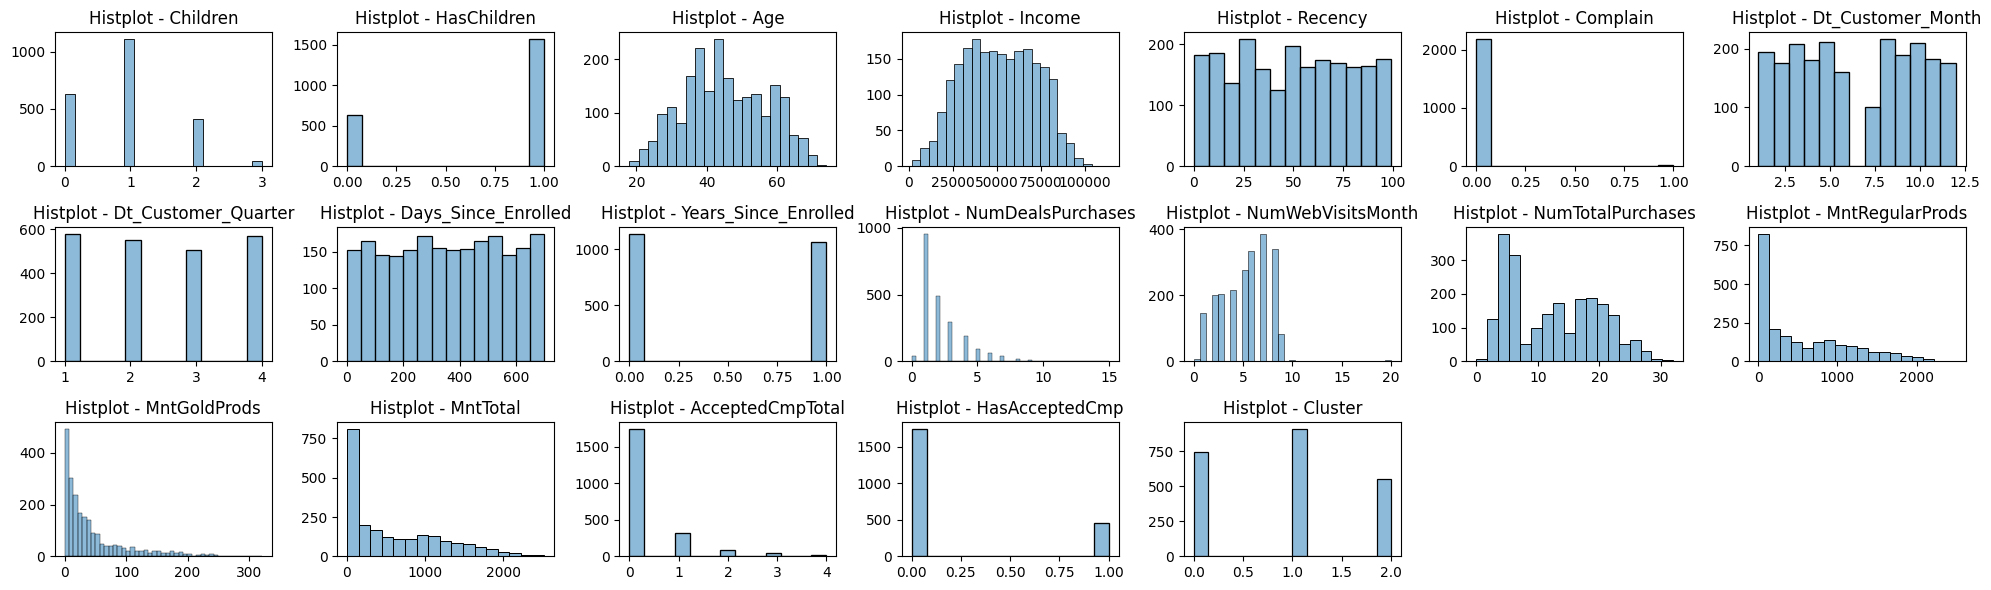

In [18]:
print('- Gráfico: Histograma.')

fn_charts_pandas.histplot(X_pd, numerical_features, num_cols = 7, height_figsize = 2)

plt.savefig(f'../images/outputs/charts/pyspark/nb07_histplot.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 07.3.4. Definindo o pré processamento das colunas de acordo com a distribuição dos seus dados

- **One Hot Encoder:** Indicado para colunas categóricas ou que possuem inteiros discretos.
- **Standard Scaler:** Indicado para colunas com distribuição semelhante à normal.
- **Power Transformer:** Indicado para colunas com assimetria dos dados.
- **Min-Max Scaler:** Indicado para colunas com distribuição uniforme dos dados.

In [19]:
one_hot_encoder_columns = [
    'Education',
    'Marital_Status',
    'AgeGroup',
    'Children',
    'HasChildren',
    'Complain',
    'Years_Since_Enrolled',
    'AcceptedCmpTotal',
    'HasAcceptedCmp',
    'Cluster',
]

standard_scaler_columns = [
    'Income',
    'Age',
]

power_transformer_columns = [
   'NumDealsPurchases',
   'NumWebVisitsMonth',
   'NumTotalPurchases',
   'MntRegularProds',
   'MntGoldProds',
   'MntTotal',
]

min_max_scaler_columns = [
    'Recency',
    'Dt_Customer_Month',
    'Dt_Customer_Quarter',
    'Days_Since_Enrolled',
]

### 07.3.5. Criando uma função com o pipeline para treinar os modelos

In [20]:
def pipeline(X: pd.DataFrame, y: pd.Series, model: BaseEstimator) -> dict[str, Any]: 
    """
    Função que executa todo o fluxo de machine learning: pré-processamento, seleção de features,
    balanceamento de classes, treinamento do modelo e validação cruzada.

    Args:
        X (pd.DataFrame): Valores de X.
        y (pd.Series): Variável alvo.
        model (BaseEstimator): Modelo de machine learning.

    Returns:
        dict: Dicionário com as métricas dos treinamentos.
    """

    pre_processing = ColumnTransformer(

        [

            ('one_hot_encoder', OneHotEncoder(), one_hot_encoder_columns),

            ('standard_scaler', StandardScaler(), standard_scaler_columns),

            ('power_transformer', PowerTransformer(), power_transformer_columns),

            ('min_max_scaler', MinMaxScaler(), min_max_scaler_columns)

        ]

    )

    pipeline = Pipeline(

        [

            ('pre_processing', pre_processing), 

            ('feature_selection', SelectKBest(score_func = f_classif, k = 10)), 

            ('resampling', RandomUnderSampler(random_state = consts.RANDOM_STATE)), 

            ('model', model), 

        ]

    )

    scores = cross_validate(
        
        pipeline, 

        X, 

        y, 

        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = consts.RANDOM_STATE), 

        scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'], 

        n_jobs = -2, 

    )

    return scores 

### 07.3.6. Treinando os modelos e armazenando suas métricas

In [21]:
scores = {

    'DummyClassifier': pipeline(X_pd, y_pd, DummyClassifier(strategy = 'stratified', random_state = consts.RANDOM_STATE)),

    'DecisionTreeClassifier': pipeline(X_pd, y_pd, DecisionTreeClassifier(random_state = consts.RANDOM_STATE)),

    'LogisticRegression': pipeline(X_pd, y_pd, LogisticRegression(random_state = consts.RANDOM_STATE)),

    'KNNClassifier': pipeline(X_pd, y_pd, KNeighborsClassifier(n_neighbors = 5)),

    'SVC': pipeline(X_pd, y_pd, SVC(random_state = consts.RANDOM_STATE)),

    'ExtraTreesClassifier': pipeline(X_pd, y_pd, ExtraTreesClassifier(random_state = consts.RANDOM_STATE)),

    'RandomForestClassifier': pipeline(X_pd, y_pd, RandomForestClassifier(random_state = consts.RANDOM_STATE)),

    'AdaBoostClassifier': pipeline(X_pd, y_pd, AdaBoostClassifier(random_state = consts.RANDOM_STATE)),

    'XGBClassifier': pipeline(X_pd, y_pd, XGBClassifier(random_state = consts.RANDOM_STATE)),

}

### 07.3.7. Evitando overfitting dos modelos

- **Feature Selection:** No aspecto de Feature Selection, foi aplicado o SelectKBest para selecionar as melhores features (colunas) para a criação do modelo, de modo que estivessem somente as features mais relevantes para o modelo e que não houvesse dados redundantes.
- **Balanceamento de Classes:** No aspecto de Balanceamento de Classes, como o dataset do projeto é desbalanceado, foi aplicado a técnica de Random Under Sampling (RUS) para se equiparar os valores da classe target ("Response"), onde se reduz a quantidade de valores da classe majoritária até que fique igual aos valores da classe minoritária.
- **Validação Cruzada:** No aspecto de Validação Cruzada, foi aplicado o Stratified K-Fold, por ser um dataset desbalanceado, para dividir o conjunto de treinamento em várias partes (folds) e realizar o treinamento e validação do modelo em combinações diferentes desses folds, de modo que se obtém resultados mais confiáveis das métricas de avaliação do modelo e reduz o viés associado a uma única divisão do conjunto de treinamento.
- **Regularização:** No aspecto de Regularização, foi aplicado a regularização L2 (Ridge) para adicionar uma penalidade ao modelo com base no coeficientes dos parâmetros, de modo que os coeficientes se tornem muito grandes e assim reduzindo o overfitting.

## 07.4. Seleção do modelo de classificação

### 07.4.1. Criando um dataset com as métricas dos treinamentos dos modelos

In [22]:
pd.set_option('display.max_rows', None)

for k, v in scores.items(): 

    scores[k]['time'] = scores[k]['fit_time'] + scores[k]['score_time'] 

df_metrics = pd.DataFrame(scores).T.reset_index().rename(columns = {'index': 'model'}) 

df_metrics = df_metrics.explode(df_metrics.columns[1:].to_list()).reset_index(drop = True) 

df_metrics = df_metrics.rename(columns = lambda c: c.replace('test_', ''))

df_metrics = df_metrics.drop(columns = ['fit_time', 'score_time'])

df_metrics

,model,accuracy,precision,recall,roc_auc,average_precision,time
0,DummyClassifier,0.510204,0.149533,0.484848,0.499758,0.149598,0.092312
1,DummyClassifier,0.501134,0.140187,0.454545,0.481939,0.145354,0.097761
2,DummyClassifier,0.512472,0.154206,0.492537,0.50429,0.15305,0.113799
3,DummyClassifier,0.512472,0.154206,0.492537,0.50429,0.15305,0.098652
4,DummyClassifier,0.507937,0.149533,0.477612,0.49549,0.150784,0.105662
5,DecisionTreeClassifier,0.643991,0.24,0.636364,0.639879,0.207149,0.102006
6,DecisionTreeClassifier,0.748299,0.346939,0.772727,0.758061,0.302103,0.092726
7,DecisionTreeClassifier,0.653061,0.252874,0.656716,0.653644,0.21822,0.09301
8,DecisionTreeClassifier,0.641723,0.233918,0.597015,0.626068,0.202086,0.094464
9,DecisionTreeClassifier,0.646259,0.251397,0.671642,0.655799,0.218735,0.095681


### 07.4.2. Criando diagramas de caixa para comparar as métricas dos modelos

- Gráfico: Diagrama de Caixa.


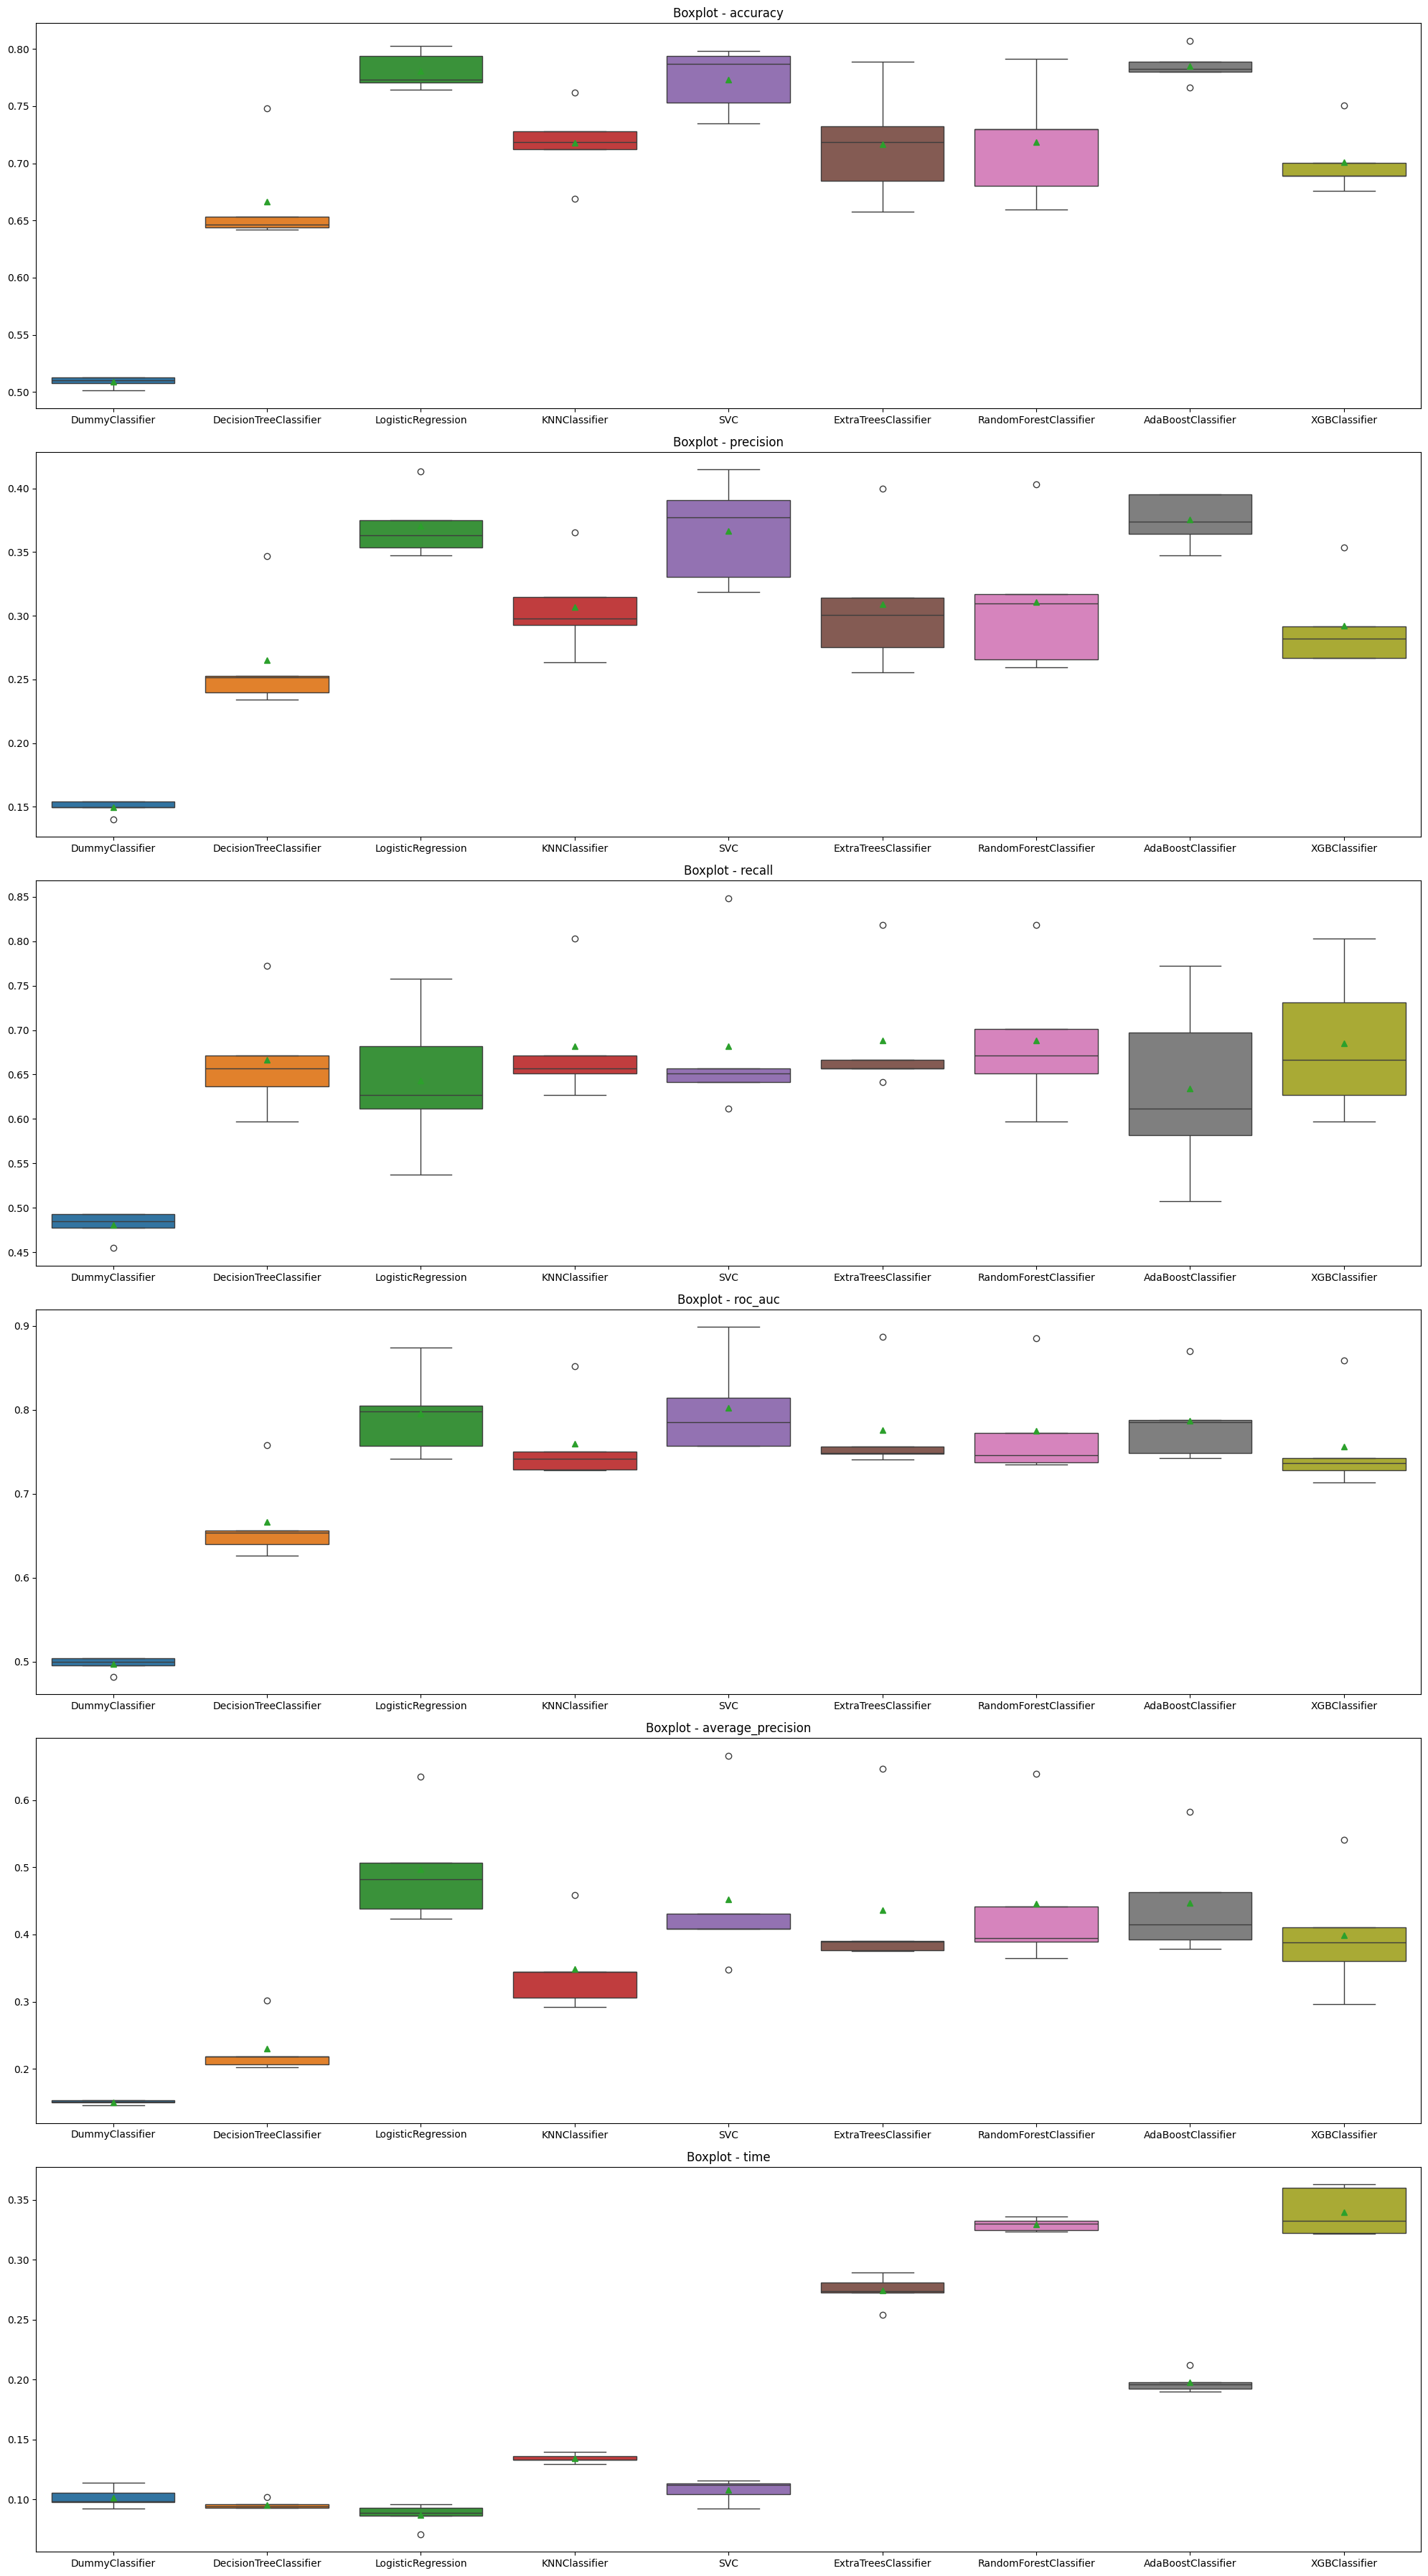

In [23]:
print('- Gráfico: Diagrama de Caixa.')

fn_charts_pandas.boxplot(df_metrics, df_metrics.columns[1:].to_list(), 'model', 'model', num_cols = 1, height_figsize = 6)

plt.savefig(f'../images/outputs/charts/pyspark/nb07_boxplot_models.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 07.4.3. Comparando a performance das métricas dos modelo

|Posição|Accuracy|Precision|Recall|ROC_AUC|Average Precision|Time|
|------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|
|Referência|Quanto maior melhor|Quanto maior melhor|Quanto maior melhor| Quanto maior melhor|Quanto maior melhor|Quanto menor melhor|
|1|AdaBoostClassifier|AdaBoostClassifier|SVC|SVC|**LogisticRegression**|DecisionTreeClassifier|
|2|**LogisticRegression**|**LogisticRegression**|KNNClassifier|AdaBoostClassifier|AdaBoostClassifier|DummyClassifier|
|3|SVC|SVC|AdaBoostClassifier|**LogisticRegression**|SVC|KNNClassifier|
|4|KNNClassifier|KNNClassifier|**LogisticRegression**|RandomForestClassifier|ExtraTreesClassifier|**LogisticRegression**|
|5|ExtraTreesClassifier|ExtraTreesClassifier|RandomForestClassifier|ExtraTreesClassifier|RandomForestClassifier|SVC|
|6|RandomForestClassifier|RandomForestClassifier|ExtraTreesClassifier|KNNClassifier|XGBClassifier|AdaBoostClassifier|
|7|XGBClassifier|XGBClassifier|XGBClassifier|XGBClassifier|KNNClassifier|ExtraTreesClassifier|
|8|DecisionTreeClassifier|DecisionTreeClassifier|DecisionTreeClassifier|DecisionTreeClassifier|DecisionTreeClassifier|RandomForestClassifier|
|9|DummyClassifier|DummyClassifier|DummyClassifier|DummyClassifier|DummyClassifier|XGBClassifier|

### 07.4.4. Definindo o modelo selecionado

Após análise dos resultados de cada um dos modelos, é possível concluir que o modelo com os melhores resultados foi o de Logistic Regression, pois esteve nas primeiras posições nos resultados das métricas de Accuracy, Precision, ROC_AUC, Average Precision, apesar de ter ficado na mediana em relação ao Recall e ao Time. Além disso, no caso de datasets desbalanceados como é o caso desse estudo, as principais métricas avaliadas são o ROC_AUC e o Average Precision, onde o modelo de Logistic Regression também obteve as melhores performances combinadas. E em relação ao processamento, esse modelo também teve uma boa performance com um tempo de processamento dentro do normal.

Portando, diante de todo esse contexto, **o melhor modelo para ser usado no projeto é o Logistic Regression**. Porém é importante destacar que os modelos Ada Boost e SVC também tiveram desempenhos muito bons.

**Obs:** A tabela acima foi feita em cima de uma execução específica do notebook. A cada execução do notebook é possível que os valores das métricas variem um pouco, por isso pode ser que a tabela apresente uma ordem dos resultados levemente diferente de quando foi elaborada.